In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/CIFAR10"

/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/CIFAR10


In [3]:
## load package
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# load build-in dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [6]:
## reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)


In [7]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

In [8]:
x_split_train, x_split_validation, y_split_train, y_split_validation = train_test_split(x_train,y_train_one_hot, train_size=0.8)

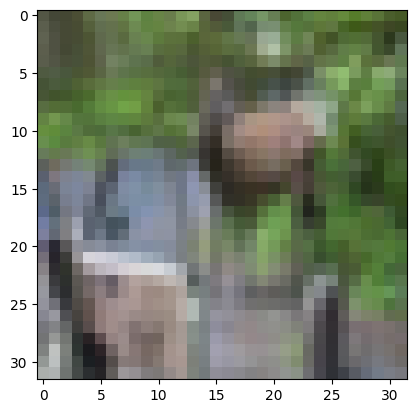

In [9]:
plt.imshow(x_split_train[0])

In [10]:
## define the model architecture

model = Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
# model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
  )

In [12]:
## Trainning the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=20)

it_train = datagen.flow(x_split_train,y_split_train)

history = model.fit(it_train,epochs=80,validation_data=(x_split_validation,y_split_validation), verbose=1, callbacks=[reduce_lr])

Epoch 1/2
1250/1250 [==============================] - 37s 19ms/step - loss: 1.6405 - categorical_accuracy: 0.4157 - val_loss: 1.3271 - val_categorical_accuracy: 0.5328 - lr: 0.0010
Epoch 2/2
1250/1250 [==============================] - 23s 18ms/step - loss: 1.2339 - categorical_accuracy: 0.5581 - val_loss: 1.0924 - val_categorical_accuracy: 0.6142 - lr: 0.0010


In [13]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

In [14]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure()
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='test')
    


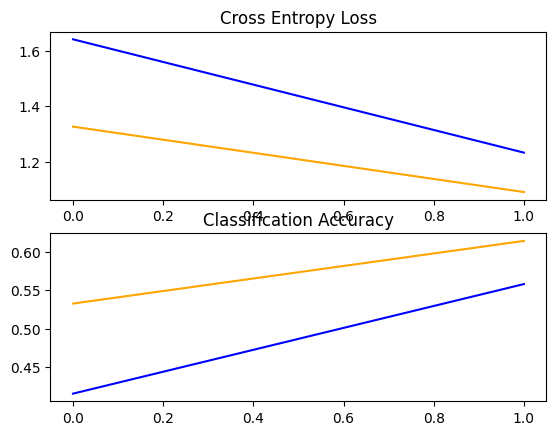

In [15]:
summarize_diagnostics(history)

In [16]:
obtained_learning_rate = np.array(history.history['lr'])
def scheduler(epoch):
  return obtained_learning_rate[epoch]
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
obtained_learning_rate

array([0.001, 0.001], dtype=float32)

In [18]:
## define the model architecture

final_model = Sequential()
final_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.MaxPooling2D((2, 2)))
# model.add(keras.layers.Dropout(0.2))
final_model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.Conv2D(64, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.MaxPooling2D((2, 2)))
# model.add(keras.layers.Dropout(0.3))
final_model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.Conv2D(128, (3, 3),kernel_initializer='he_uniform', padding='same', activation='relu'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.MaxPooling2D((2, 2)))
final_model.add(keras.layers.Dropout(0.2))
final_model.add(keras.layers.Flatten())
final_model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.Dropout(0.2))
final_model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
final_model.add(keras.layers.BatchNormalization())
final_model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dropout(0.5))
final_model.add(keras.layers.Dense(10, activation='softmax'))

final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
  )

In [20]:
nit_train = datagen.flow(x_train, y_train_one_hot)

In [21]:
with tf.device('/device:GPU:0'):
  final_history = final_model.fit(nit_train, epochs=80, validation_data=(x_test, y_test_one_hot), verbose=1, callbacks=[callback])

Epoch 1/2
1563/1563 [==============================] - 35s 18ms/step - loss: 1.5916 - categorical_accuracy: 0.4371 - val_loss: 1.2085 - val_categorical_accuracy: 0.5691 - lr: 0.0010
Epoch 2/2
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1402 - categorical_accuracy: 0.5976 - val_loss: 1.0969 - val_categorical_accuracy: 0.6212 - lr: 0.0010


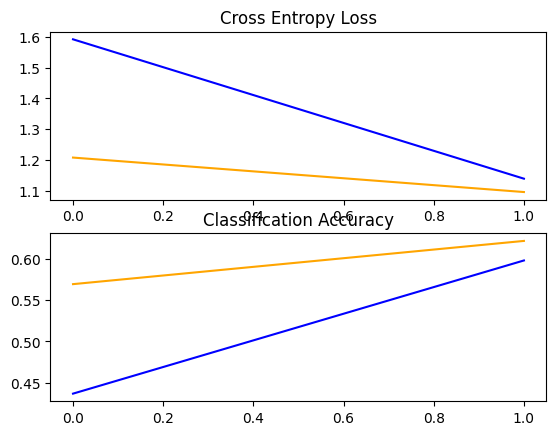

In [22]:
summarize_diagnostics(final_history)

In [23]:
# evaluate the model
result = final_model.evaluate(x_test, y_test_one_hot, verbose=1)


313/313 [==============================] - 1s 3ms/step - loss: 1.0969 - categorical_accuracy: 0.6212


In [24]:
result[1]*100

62.12000250816345

In [25]:
final_model.save('CIFAR10_self_build_model_new.h5')